# Выборка #7

In [152]:
%run init.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Обзор данных

In [153]:
dataset = Dataset(7)
dataset.summary()

+---------+-----------------------+----------------------+-------------+------------------+
| Выборка | Обучающая, # объектов | Тестовая, # объектов | # признаков | Доля класса 1, % |
+---------+-----------------------+----------------------+-------------+------------------+
|    7    |          1000         |         1000         |      50     |       13.2       |
+---------+-----------------------+----------------------+-------------+------------------+


Попробуем сбалансировать выборку оверсэмплингом

In [156]:
dataset.X1, dataset.X2, dataset.y1, dataset.y2 = train_test_split(dataset.X1, dataset.y1, test_size = 0.3, stratify = dataset.y1)

In [154]:
from imblearn.over_sampling import SMOTE
#'minority': повторная выборка только класса меньшинства; 
#'not majority': повторная выборка всех классов кроме большого; 
smote = SMOTE(sampling_strategy ='not majority')
X_sm, y_sm = smote.fit_resample(dataset.X1, dataset.y1)
print(y_sm.shape)
print(X_sm.shape)

(1736,)
(1736, 50)


In [160]:

dataset.n_samples = 1215
dataset.X1.shape

(1215, 50)

In [155]:
dataset.X1 = X_sm
dataset.y1 = y_sm

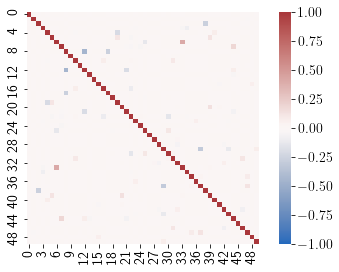

In [71]:
dataset.heatmap()

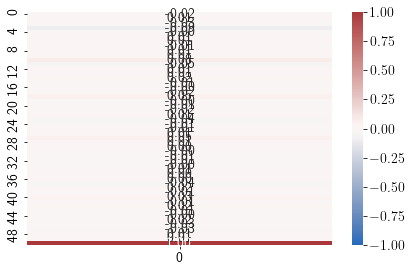

In [72]:
dataset.target_corr()

In [59]:
# make_histplot(dataset.df)

In [60]:
#D_kls = dataset.divergences(verbose=False)

In [61]:
#D_kls[D_kls > 1000].shape[0]

In [62]:
# dataset.approx(number_of_feature = 5)

### Проверка нормальности признаков

Используем критерий Шапиро-Уилка

In [73]:
pvals = [shapiro(dataset.X1[i])[1] for i in range(dataset.n_features)]

Получим достигаемые уровни значимости для нулевой гипотезы: "Распределение признака является нормальным"

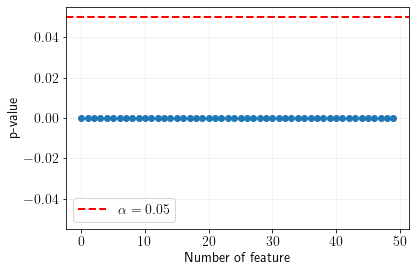

In [74]:
plt.plot(pvals, linestyle='None', marker='o')
plt.axhline(y=0.05, color='r', linestyle='dashed', label=r'$\alpha=0.05$')

plt.legend()
plt.xlabel('Number of feature')
plt.ylabel('p-value')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f'./fig/dataset_{dataset.dataset_id}/shapiro.pdf', bbox_inches='tight')
plt.show()

Мы с уверенностью можем отвергнуть поставленную гипотезу для каждого признака. Рассмотрим поподробнее, что же с ними происходит.

In [76]:
#plt.figure(figsize=(16, 4))
#dataset.X1[3].plot()

Исключим все объекты со значениями признаков < 0.025-квантиля и больше > 0.975-квантиля

In [161]:
X1_stage1 = dataset.X1[dataset.X1 > dataset.X1.quantile(q=0.05)][dataset.X1 < dataset.X1.quantile(q=0.95)]

аналогично для тестовых данных

In [162]:
X2_stage1 = dataset.X2[dataset.X2 > dataset.X1.quantile(q=0.05)][dataset.X2 < dataset.X1.quantile(q=0.95)]

Заполним все пропущенные значения средними значениями по каждому признаку

In [163]:
X1_stage2 = X1_stage1.fillna(X1_stage1.mean())

In [164]:
X2_stage2 = X2_stage1.fillna(X1_stage1.mean())

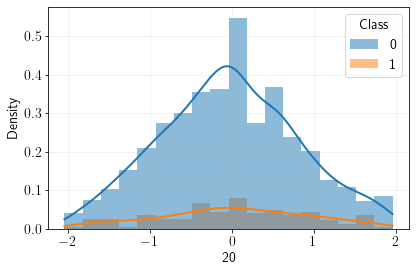

In [70]:
df = pd.concat([X1_stage2, dataset.y1], axis=1)

sns.histplot(data=df, x=df[20], stat='density', hue='Class', kde=True, edgecolor=None)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

Проверим гипотезу для уже отфильтрованных признаков

In [7]:
pvals = [shapiro(X1_stage2[i])[1] for i in range(dataset.n_features)]

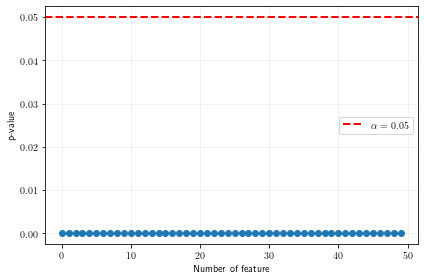

In [8]:
plt.plot(pvals, linestyle='None', marker='o')
plt.axhline(y=0.05, color='r', linestyle='dashed', label=r'$\alpha=0.05$')

plt.legend()
plt.xlabel('Number of feature')
plt.ylabel('p-value')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

Очень похоже на то, что признаки имеют распределение Лапласа.

In [73]:
loc, scale = laplace.fit(X1_stage2[0])

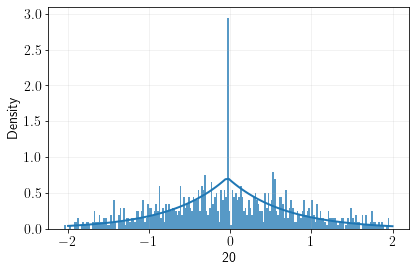

In [74]:
x = np.linspace(-2, 2, 100)
plt.plot(x, laplace.pdf(x, loc=loc, scale=scale))

df = pd.concat([X1_stage2, dataset.y1], axis=1)
sns.histplot(data=df, x=df[20], bins=200, stat='density', edgecolor=None)

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

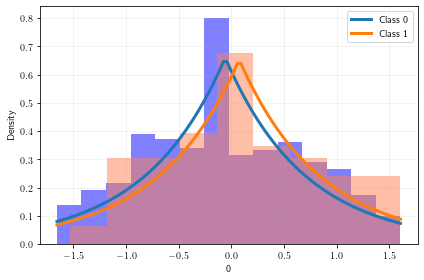

In [9]:
loc_1, scale_1 = norm.fit(X1_stage2[0][dataset.y1 == 1])
loc_0, scale_0 = norm.fit(X1_stage2[0][dataset.y1 == 0])

sns.histplot(X1_stage2[0][dataset.y1 == 0], color='blue', stat='density', edgecolor=None, alpha=0.5)
sns.histplot(X1_stage2[0][dataset.y1 == 1], color='coral', stat='density', edgecolor=None, alpha=0.5)

grid = np.linspace(min(X1_stage2[0]), max(X1_stage2[0]), 100)
plt.plot(grid, laplace.pdf(grid, loc=loc_0, scale=scale_0), linewidth=3, label='Class 0')
plt.plot(grid, laplace.pdf(grid, loc=loc_1, scale=scale_1), linewidth=3, label='Class 1')

plt.legend()
plt.grid(alpha=0.2)
plt.savefig(f'./fig/dataset_{dataset.dataset_id}/Laplas.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

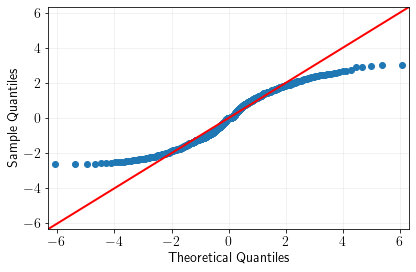

In [76]:
qqplot(data=X1_stage2[0][dataset.y1 == 0], dist=laplace, fit=True, line='45')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

---

---

### Logistic Regression

Используем предобработанные от выбросов данные (отбор дает выигрыш в AUC):

In [165]:
dataset.X1 = X1_stage2 
dataset.X2 = X2_stage2

In [166]:
dataset.get_scaled_data()

Отшкалируем предобработанные данные:

In [32]:
dataset.get_scaled_data()
dataset.get_divergences()

c:\Users\Чёрный господин\Documents\GitHub\Bayesian-Model-Selection\prac1\utils.py:290: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x0 = self.X1_scaled[self.y1 == 0][j]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


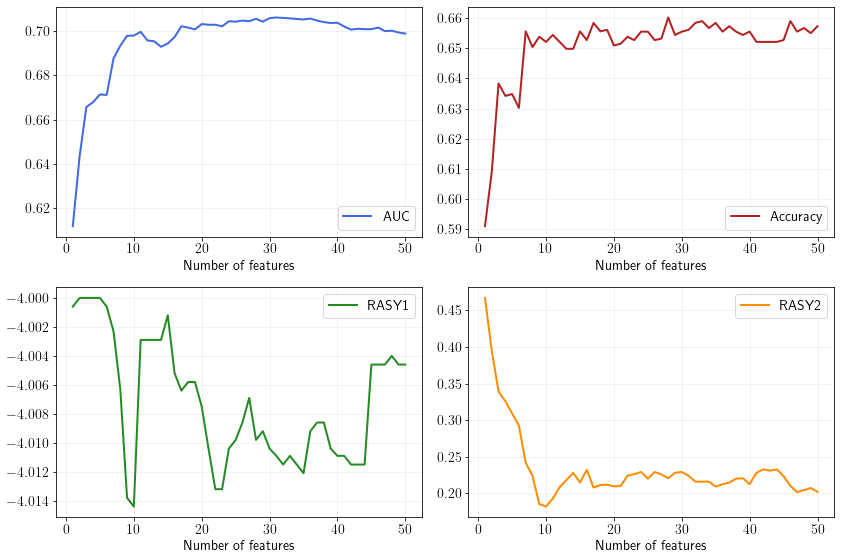

In [111]:
features_cols_lr = dataset.metrics_n_features_dependence(LogisticRegression(), save=False)

100%|██████████| 21/21 [00:21<00:00,  1.03s/it]


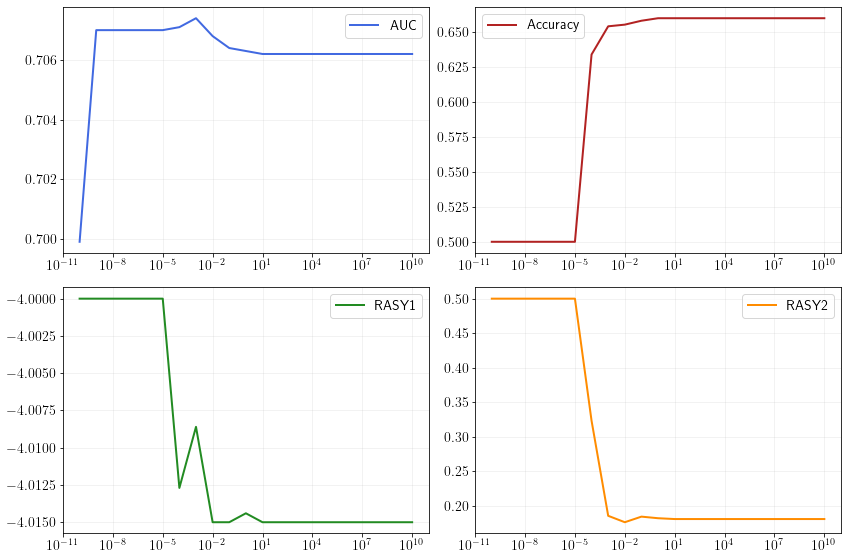

In [112]:
Cs_lr = LogisticRegressionValidate(dataset, features_cols_lr, np.logspace(-10, 10, 21), save=False)

### Наивный байес

100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


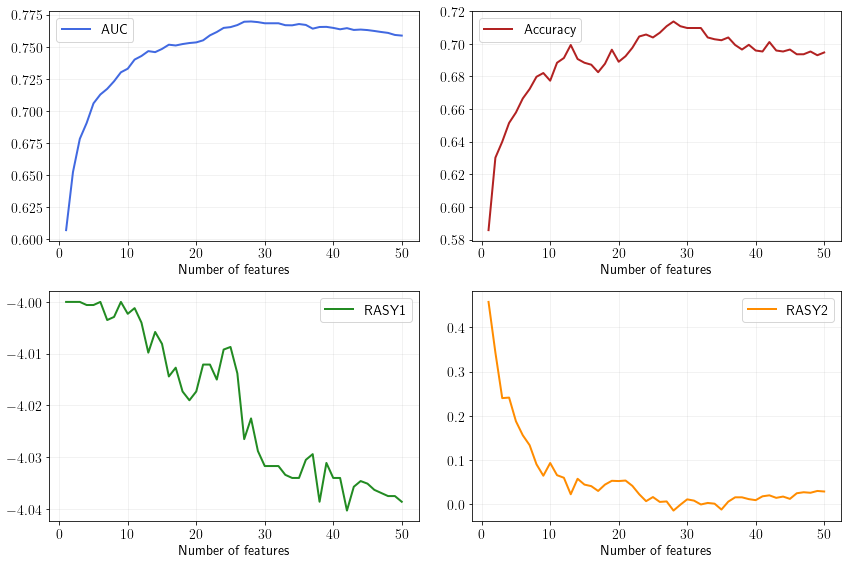

In [167]:
features_cols_gnb = dataset.metrics_n_features_dependence(GaussianNB())

### CatBoost (плохо себя показывает)

In [110]:
#fit_params = {"verbose" : False, "plot" : False}

In [101]:
#dataset.metrics_n_features_dependence(CatBoostClassifier(), fit_params=fit_params,
                                      #ks=range(1, dataset.df.shape[1], 15))

In [102]:
#features_cb, cols_cb = dataset.feature_selection(n_cols=9)

In [103]:
#depths = [2, 3, 4, 5, 6, 7]
#CatBoostClassifierValidate(dataset, features_cb, depths)

In [167]:
# тест
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
clf.fit(dataset.X1, dataset.y1)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [168]:
y_p = clf.predict_proba(dataset.X2)

In [136]:
from sklearn.metrics import accuracy_score, f1_score, auc
import sklearn

accuracy_score(y_p, dataset.y2)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [169]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(dataset.y2, y_p[:,1])

auc(fpr, tpr)

0.955238726790451

In [91]:
dataset.y2.shape

(157,)

100%|██████████| 50/50 [09:34<00:00, 11.49s/it]


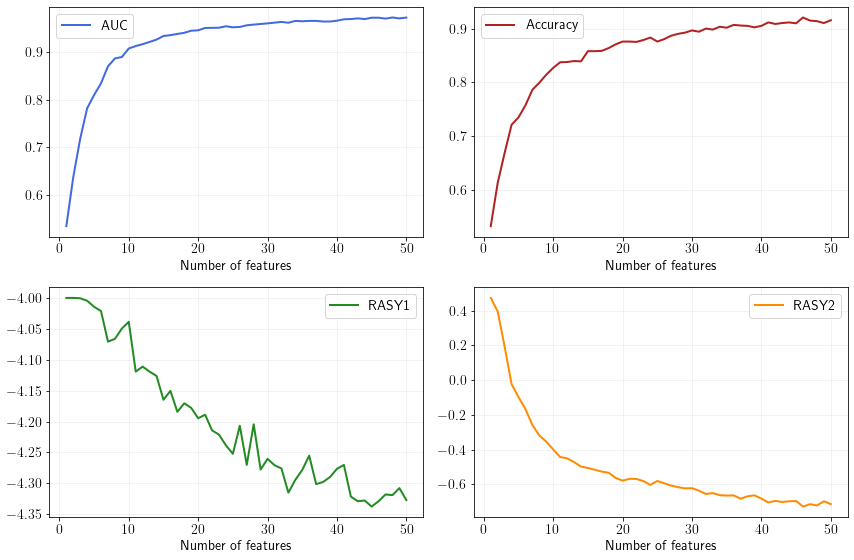

In [147]:
from sklearn.ensemble import RandomForestClassifier

features_cols_rfc = dataset.metrics_n_features_dependence(RandomForestClassifier(n_estimators = 500, n_jobs = -1))

### Saving aswers 

In [162]:
model_AUC = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
model_Accuracy = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
model_RASY1 = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
model_RASY2 = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
models = [model_AUC, model_Accuracy, model_RASY1, model_RASY2]

In [163]:
features_AUC, cols_AUC = features_cols_rfc['AUC']['features'], features_cols_rfc['AUC']['cols']
features_Accuracy, cols_Accuracy = features_cols_rfc['Accuracy']['features'], features_cols_rfc['Accuracy']['cols']
features_RASY1, cols_RASY1 = features_cols_rfc['RASY1']['features'], features_cols_rfc['RASY1']['cols']
features_RASY2, cols_RASY2 = features_cols_rfc['RASY2']['features'], features_cols_rfc['RASY2']['cols']
features_list = [features_AUC, features_Accuracy, features_RASY1, features_RASY2]
cols_list = [cols_AUC, cols_Accuracy, cols_RASY1, cols_RASY2]

In [164]:
t_Accuracy = features_cols_rfc['Accuracy']['t']
t_RASY1 = features_cols_rfc['RASY1']['t']
t_RASY2 = features_cols_rfc['RASY2']['t']
thresholds_list = [t_Accuracy, t_RASY1, t_RASY2]

In [165]:
dataset.save_ans(models, features_list, cols_list, thresholds_list)

In [47]:
cols_list


[array([15, 37, 43, 38, 14,  9, 42, 16, 47], dtype=int64),
 array([15, 37, 43, 38, 14,  9, 42, 16, 47,  7,  2, 10,  0, 40, 13, 20, 36,
        35, 26, 39], dtype=int64),
 array([15, 37, 43, 38, 14,  9, 42, 16, 47,  7,  2, 10,  0, 40, 13, 20, 36,
        35, 26, 39], dtype=int64),
 array([15, 37, 43, 38, 14,  9, 42, 16, 47,  7,  2, 10,  0, 40, 13, 20, 36,
        35, 26, 39], dtype=int64)]

In [166]:
print(f'{thresholds_list[0]:.2f}, {thresholds_list[1]:.2f}, {thresholds_list[2]:.2f}')

0.49, 0.63, 0.52
